<a href="https://colab.research.google.com/github/sarahaptumich/capstone/blob/shaptonstall/Brace_angles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Mount google drive
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/Github/capstone/brace

/content/drive/MyDrive/Github/capstone/brace


In [ ]:
%ls

 annotations/      dataset/              labels                  README.md
 bracedataset.py   dataset_pytorch.py    lstm_model2.pth         tensor_dataset.pkl
 brace_test.pkl    figures/              lstm_model.pth          test_subset.pkl
 brace_test.pth    keras_model/         'MODELS ACCURACY.gdoc'   timeDistModel/
 brace_train.pkl   keypoints_angles.py   names                   train_subset.pkl
 brace_train.pth   k_model_features/     path/                   utils/
 dataClips         k_model_features2/    __pycache__/            videos_info.csv


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Github/capstone/brace')

In [ ]:
#only import to get funtion names
import inspect
import keypoints_angles
function_list = [o for o in dir(keypoints_angles) if inspect.isfunction(getattr(keypoints_angles, o))]
print(function_list)

['body_parts', 'calculate_angle', 'calculate_angle_to_horizontal', 'calculate_hand_to_floor_distance', 'calculate_head_position', 'calculate_head_to_floor_distance', 'calculate_leg_angles', 'calculate_mean_angles', 'calculate_mean_distance', 'calculate_mean_hand_distance', 'calculate_mean_leg_angles', 'extract_angles_from_dataset', 'extract_hand_to_floor_distances', 'extract_head_to_floor_distances', 'extract_horizontal_angles_from_df', 'plot_hand_distance_3x2_with_category_names', 'plot_head_to_floor_histograms', 'plot_hip_knee_floor', 'plot_hip_leg_angle']


In [ ]:
import pickle
from keypoints_angles import body_parts, calculate_angle, calculate_angle_to_horizontal, calculate_hand_to_floor_distance, calculate_head_position
from keypoints_angles import calculate_head_to_floor_distance, calculate_leg_angles, calculate_mean_angles, calculate_mean_distance
from keypoints_angles import calculate_mean_hand_distance, calculate_mean_leg_angles, extract_angles_from_dataset, extract_hand_to_floor_distances
from keypoints_angles import  extract_head_to_floor_distances, extract_horizontal_angles_from_df, plot_hand_distance_3x2_with_category_names
from keypoints_angles import plot_head_to_floor_histograms, plot_hip_knee_floor, plot_hip_leg_angle
import pandas as pd
import numpy as np

Import keypoint and labels

In [ ]:
# Load the TensorDataset
with open('dataClips', 'rb') as f:
    dataClips = pickle.load(f)

# Load the training Subset
with open('labels', 'rb') as f:
    labels = pickle.load(f)

# Load the testing Subset
with open('names', 'rb') as f:
    names = pickle.load(f)

#encode labels from 0-2
unique_categories = list(set(labels))
category_to_int = {category: index for index, category in enumerate(unique_categories)}
encoded_categories = [category_to_int[category] for category in labels]
#get flatted clips
flattened_clips = [clip.reshape(clip.shape[0], -1) for clip in dataClips]

Calculate Keypoint angles

In [ ]:
df_body_parts = pd.DataFrame(list(body_parts().keys()), index=body_parts().values(), columns=['bodyParts'])
df_body_parts

,bodyParts
0,Nose
1,Left Eye
2,Right Eye
3,Left Ear
4,Right Ear
5,Left Shoulder
6,Right Shoulder
7,Left Elbow
8,Right Elbow
9,Left Wrist


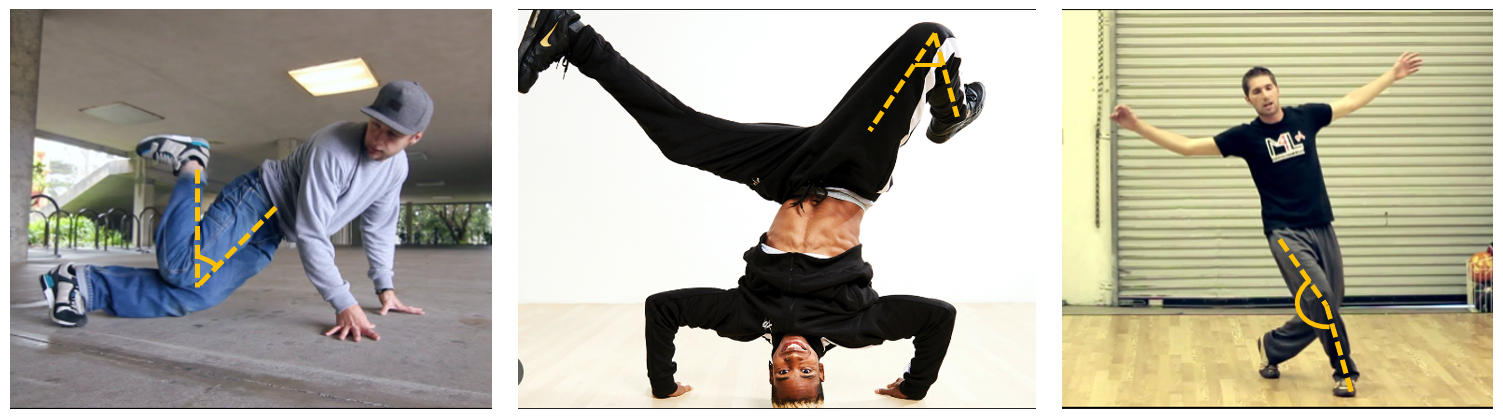

In [ ]:
# Keypoint indices for right and left legs
right_keypoints = [12, 14, 16]
left_keypoints = [11, 13, 15]
category_to_int= {'toprock': 0, 'powermove': 1, 'footwork': 2}

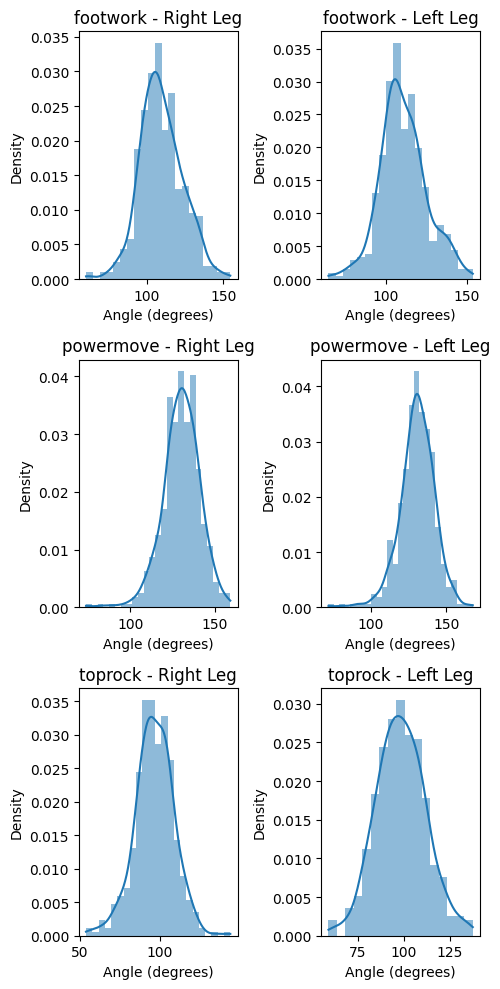

In [ ]:
class_angles_hka =extract_angles_from_dataset(flattened_clips, encoded_categories, right_keypoints, left_keypoints)
plot_hip_leg_angle(class_angles_hka, category_to_int)

In [ ]:
mean_angles = calculate_mean_angles(class_angles_hka)
int_to_category = {v: k for k, v in category_to_int.items()}
# Print mean angles for each class and each leg
for label in mean_angles:
    category_name = int_to_category[label]
    print(f"Class {category_name} - Mean Right Leg Angle: {mean_angles[label]['right']:.2f}, Mean Left Leg Angle: {mean_angles[label]['left']:.2f}")

Class toprock - Mean Right Leg Angle: 96.61, Mean Left Leg Angle: 98.48
Class powermove - Mean Right Leg Angle: 130.20, Mean Left Leg Angle: 130.64
Class footwork - Mean Right Leg Angle: 109.39, Mean Left Leg Angle: 110.93


Hip Knee horizontal line calculate if the hips are parallel or below the knee like then squatting.

In [ ]:
# Keypoint indices for right and left legs (hip, knee)
right_keypoints = [12, 14]  # right hip, right knee
left_keypoints = [11, 13]  # left hip, left knee

# Assuming 'data' is your padded_clips and 'labels' correspond to y_train
hrz_class_angles = extract_horizontal_angles_from_df(flattened_clips, encoded_categories, right_keypoints, left_keypoints)


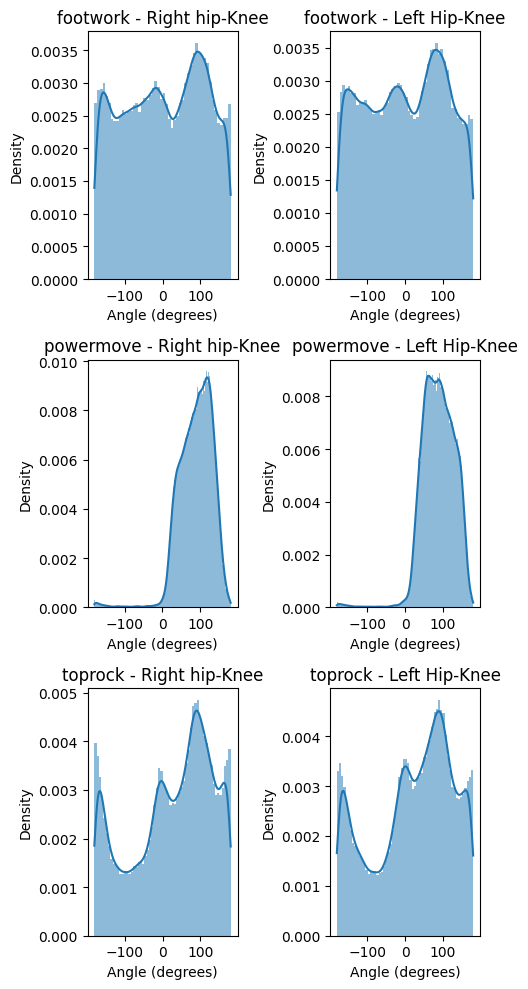

In [ ]:
plot_hip_knee_floor(hrz_class_angles, category_to_int)

In [ ]:
mean_horz_angles = calculate_mean_angles(hrz_class_angles)
int_to_category = {v: k for k, v in category_to_int.items()}
# Print mean angles for each class and each leg
for label in mean_horz_angles:
    category_name = int_to_category[label]
    print(f"Class {category_name} - Mean Right Hip-Knee-Floor Angle: {mean_horz_angles[label]['right']:.2f}, Mean Hip-Knee-Floor Angle: {mean_horz_angles[label]['left']:.2f}")

Class toprock - Mean Right Hip-Knee-Floor Angle: 24.52, Mean Hip-Knee-Floor Angle: 21.24
Class powermove - Mean Right Hip-Knee-Floor Angle: 88.57, Mean Hip-Knee-Floor Angle: 88.14
Class footwork - Mean Right Hip-Knee-Floor Angle: 2.85, Mean Hip-Knee-Floor Angle: 1.01


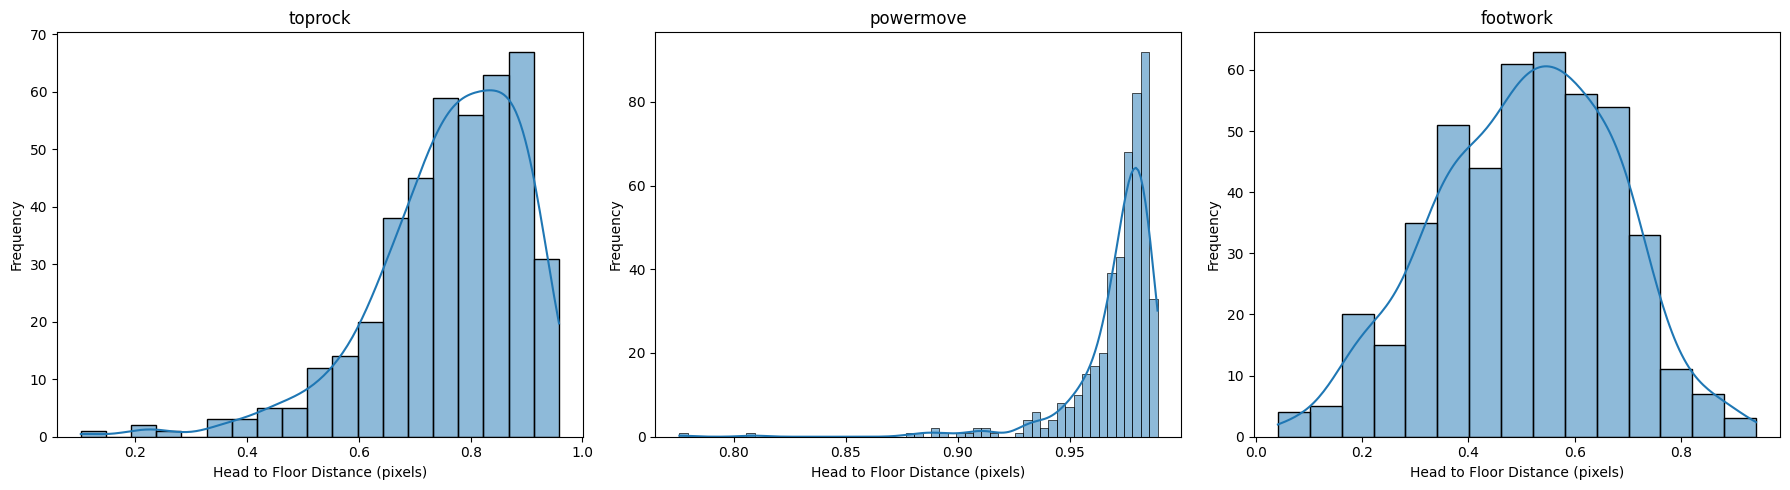

In [ ]:
head_to_floor_distances = extract_head_to_floor_distances(flattened_clips, encoded_categories, category_to_int)
plot_head_to_floor_histograms(head_to_floor_distances)

In [ ]:
head_dist= calculate_mean_distance(head_to_floor_distances)
head_dist

{'toprock': 0.7607817715982209,
 'powermove': 0.9708167567989453,
 'footwork': 0.5077703016672418}

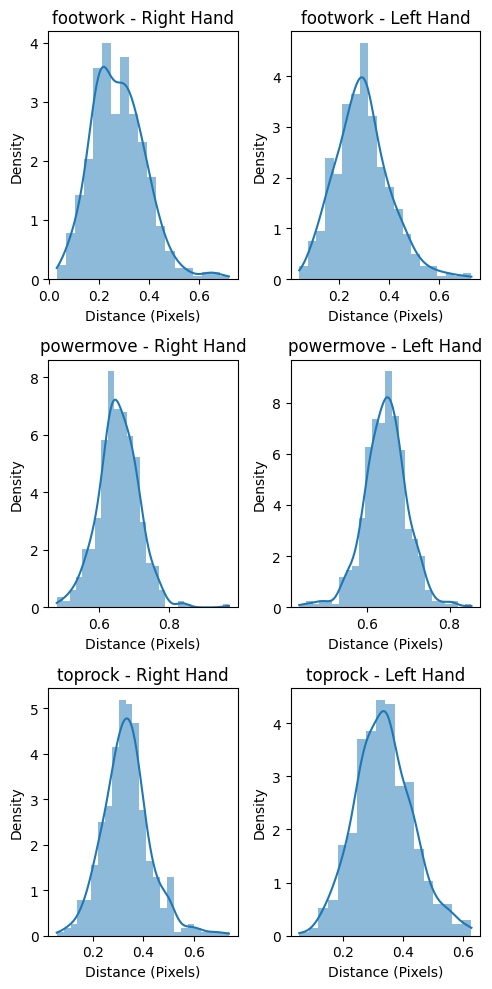

In [ ]:
hand_to_floor_distances = extract_hand_to_floor_distances(flattened_clips, encoded_categories)
plot_hand_distance_3x2_with_category_names(hand_to_floor_distances, category_to_int)

In [ ]:
mean_hand_angles = calculate_mean_hand_distance(hand_to_floor_distances)
int_to_category = {v: k for k, v in category_to_int.items()}
# Print mean angles for each class and each leg
for label in mean_hand_angles:
    category_name = int_to_category[label]
    print(f"Class {category_name} - Mean right wrist to floor distance: {mean_hand_angles[label]['right']:.2f}, Mean left wrist to floor distance: {mean_hand_angles[label]['left']:.2f}")

Class toprock - Mean right wrist to floor distance: 0.33, Mean left wrist to floor distance: 0.34
Class powermove - Mean right wrist to floor distance: 0.66, Mean left wrist to floor distance: 0.64
Class footwork - Mean right wrist to floor distance: 0.28, Mean left wrist to floor distance: 0.29
